# <img src="https://marcello-sega.github.io/pytim/_static/logo.png" alt="logo" style="width: 50px;display: inline-block;"/>  Time correlation functions

This notebook shows how to compute time correlation functions for variable groups, as in the case of the atoms belonging to a surface layer

First, we load all necessary modules to compute velocity autocorrelation functions

In [1]:
import pytim
import MDAnalysis as mda
import numpy as np

from pytim.datafiles import pytim_data, WATERSMALL_GRO
from pytim.observables import Correlator, Velocity

%matplotlib inline
from matplotlib import pyplot as plt

Since we need some statistics to calculate with a decent precision the autocorrelation function, we fetch from github a longer test trajectory:

In [15]:
TRAJ = pytim_data.fetch('WATERSMALL_LONG_TRR')

checking presence of a cached copy ... found 


and we proceed as usual to set up the universe and the interface calculation

In [16]:
u = mda.Universe(WATERSMALL_GRO,TRAJ)
g = u.select_atoms('name OW ')
inter = pytim.ITIM(u,group=g,molecular=False)

We set up now three autocorrelation function (ACF): 
1) the total velocity ACF, the one in the surface layers
2) the one of the atoms in the surface layers (that's the variable group), using only the x and y components
3) the ACF of the characteristic function of being in the surface layer, also known as survival probability 

In [17]:
# 1) the "usual" velocity ACF
total_vv = Correlator(observable=Velocity())

# 2) velocity ACF in the xy plane, using group g as a reference group (we will pass the layer group later at sampling) 
layer_vv = Correlator(observable=Velocity('xy'), reference=g)

# 3) survival probability
layer_nn = Correlator(reference=g)


We now iterate over the frames, and sample the timeseries for the ACFs, passing as argument the whole group in case #1, and the group of layer atoms (both upper and lower) in cases #2 and #3 :

In [18]:
for t in u.trajectory[1:1000:10]:
    if t.frame % 100 == 0:
        print t.frame,
    # velocity correlation of the whole set of oxygen atoms
    total_vv.sample(g)
    # velocity correlation of the surface atoms
    layer_vv.sample(inter.atoms)
    # survival probability in the first group
    layer_nn.sample(inter.atoms)

In [19]:
# 1) after the sampling of the time series is over, we compute the correlations:
vacf_total = total_vv.correlation()

In [20]:
# 2) in the variable group case, one can choose the continuous or intermittent variants. Let's check them both...
vacf_layer_continuous = layer_vv.correlation() 
vacf_layer_intermittent = layer_vv.correlation(continuous=False) 

In [21]:
# 3) the survival probability
survival_continuous = layer_nn.correlation()
survival_intermittent = layer_nn.correlation(continuous=False)

In [22]:
plt.rcParams.update({'figure.figsize' : [10.,6.]})
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.markersize':10})
plt.rcParams.update({'lines.linewidth': 3.0})

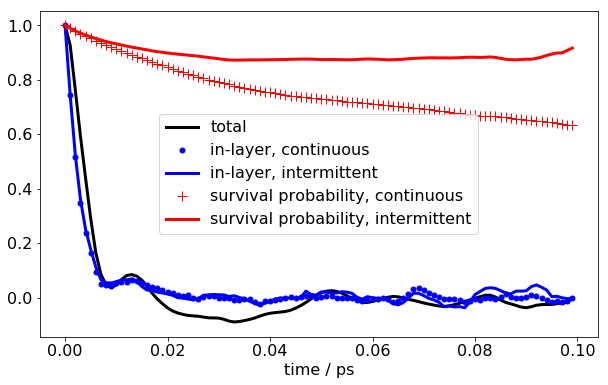

In [25]:
lim = 100
steps=1
time = u.trajectory[1].time * np.arange(lim)

plt.plot(time,vacf_total[:lim],label='total',c='black')
plt.plot(time[::steps],vacf_layer_continuous[0:lim:steps],'.',label='in-layer, continuous',c='blue')
plt.plot(time,vacf_layer_intermittent[:lim],'-',label='in-layer, intermittent',c='blue')

plt.plot(time[::steps],survival_continuous[0:lim:steps],'+',label='survival probability, continuous',c='red')
plt.plot(time,survival_intermittent[:lim],'-',label='survival probability, intermittent',c='red')

#plt.plot(time,time*0,c='gray')

plt.xlabel('time / ps')
plt.legend()
plt.show()

[ 1.          0.98975894  0.98025163  0.97215516  0.96486091  0.958073
  0.95213562  0.94623656  0.94105657]
[ 0.     0.001  0.002  0.003  0.004  0.005  0.006  0.007  0.008  0.009
  0.01   0.011  0.012  0.013  0.014  0.015  0.016  0.017  0.018  0.019
  0.02   0.021  0.022  0.023  0.024  0.025  0.026  0.027  0.028  0.029
  0.03   0.031  0.032  0.033  0.034  0.035  0.036  0.037  0.038  0.039
  0.04   0.041  0.042  0.043  0.044  0.045  0.046  0.047  0.048  0.049
  0.05   0.051  0.052  0.053  0.054  0.055  0.056  0.057  0.058  0.059
  0.06   0.061  0.062  0.063  0.064  0.065  0.066  0.067  0.068  0.069
  0.07   0.071  0.072  0.073  0.074  0.075  0.076  0.077  0.078  0.079
  0.08   0.081  0.082  0.083  0.084  0.085  0.086  0.087  0.088  0.089
  0.09   0.091  0.092  0.093  0.094  0.095  0.096  0.097  0.098  0.099]


ValueError: x and y must have same first dimension, but have shapes (100,) and (9,)

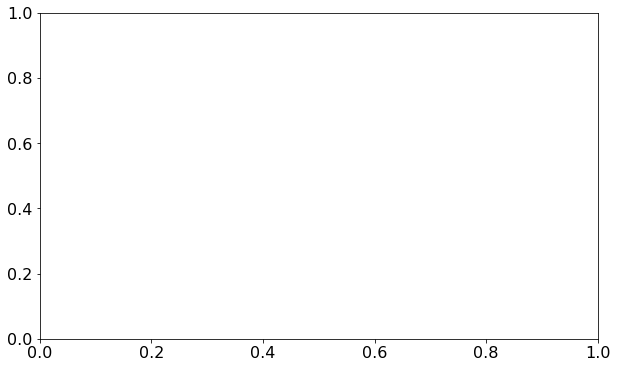

In [26]:
print survival_intermittent[:9]
print time[::steps]
plt.plot(time[::steps],survival_intermittent[:9])
plt.show()